In [29]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
from sklearn.model_selection import train_test_split

# EDA

In [30]:

diabetes_set = pd.read_csv("datos/diabetes.csv")


# Feature Selection

In [31]:
X = diabetes_set.drop(["Y"],axis = 1)
y = diabetes_set["Y"]

## Método 1: SelectFromModel (Embedded Models)

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

predictor = ExtraTreesClassifier()
predictor.fit(X, y)

model = SelectFromModel(predictor, threshold=0.11, prefit=True)
X_new = model.transform(X) 

selection = model.get_support()
num_selected_features = np.count_nonzero(selection)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
print(selection,"\n")
print("Numero de características seleccionadas: ",num_selected_features)

[False False  True False  True False False False  True  True] 

Numero de características seleccionadas:  4


## Método 2: Identificación de variables siginificativas con el estadístico t

In [34]:
x_sm = sm.add_constant(diabetes_set.drop("Y",axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,0
const,59.061427
age,-0.167570
sex,-3.917184
bmi,7.813196
bp,4.958435
s1,-1.901163
s2,1.406187
s3,0.475431
s4,1.096538
s5,4.370394


In [35]:
x_sm = sm.add_constant(diabetes_set.drop(["Y","age"],axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

,0
const,59.127978
sex,-3.957639
bmi,7.823107
bp,5.023787
s1,-1.900534
s2,1.401996
s3,0.470042
s4,1.100334
s5,4.373286
s6,1.012756


In [36]:
x_sm = sm.add_constant(diabetes_set.drop(["Y","age","s3"],axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

,0
const,59.181242
sex,-3.984963
bmi,7.818292
bp,5.017619
s1,-3.031346
s2,1.602949
s4,1.054337
s5,5.777892
s6,1.029069


**Resumen de selección de características:**

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',]

* método 1: [False False  True  True  True False False False  True  True])


* método 2: "age","s3"

# Modelo de regresión lineal

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

MAE: 45.852215383892
MSE: 3319.8487104978667
RMSE: 57.618128314774914 

MAE: 46.17886418209579
MSE: 3318.6295993871945
RMSE: 57.607548111225796 

MAE: 45.96797933499393
MSE: 3350.195212370944
RMSE: 57.88087086741995 



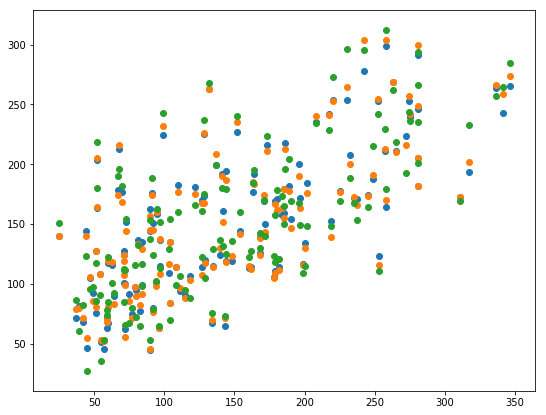

In [38]:
# esta lista contiene las variables a borrar por cada método
grid_features = [["age","sex","s1","s2","s6","Y"],["sex","s1","s4","Y"],["age","s3","Y"]]

resultados_regresion = []

plt.figure(figsize=(9,7))

def regression(lista_variables): 

    X_train, X_test, y_train, y_test = train_test_split(diabetes_set.drop(lista_variables,axis=1),diabetes_set["Y"] , test_size=0.3, random_state=101)

    lm = LinearRegression()
    lm.fit(X_train,y_train)

    predictions = lm.predict(X_test)
    
    plt.scatter(y_test,predictions)
    
    resultados_regresion.append([metrics.mean_absolute_error(y_test, predictions),
                                 metrics.mean_squared_error(y_test, predictions),
                                 np.sqrt(metrics.mean_squared_error(y_test, predictions))])
    
    print('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)),"\n")
    

for i in grid_features:
    regression(i)
    

# LR con Redes Neuronales

### Método 1: TensorFlow Api.estimator

In [39]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_set.drop(["Y"],axis=1),
                                                    diabetes_set["Y"],
                                                    test_size=0.2,
                                                    random_state=101)

X_train.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [40]:
# creo las features column (todas son numéricas)
age = tf.feature_column.numeric_column('age')
sex = tf.feature_column.numeric_column('sex')
bmi = tf.feature_column.numeric_column('bmi')
bp = tf.feature_column.numeric_column('bp')
s1 = tf.feature_column.numeric_column('s1')
s2 = tf.feature_column.numeric_column('s2')
s3 = tf.feature_column.numeric_column('s3')
s4 = tf.feature_column.numeric_column('s4')
s5 = tf.feature_column.numeric_column('s5')
s6 = tf.feature_column.numeric_column('s6')

In [41]:
feat_cols = [age,sex, bmi, bp, s1, s2, s3, s4, s5, s6]

In [42]:
# función de entrada para el entrenamiento de la red regresora
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                 y=y_train ,
                                                 batch_size=10,
                                                 num_epochs=3000,
                                                 shuffle=True)

In [43]:
# Debido al alto costo computacional de verificar cuantas neuronas y cuantas capas de deben utilizar en la red neuronal
# se asumirá un tamaño de 5 capas y se evaluará la cantidad de neuronas adecuadas para este problema.
neuronas_por_capa = [2,4,8,16,32,64]

In [44]:
from sklearn.metrics import mean_squared_error

history_neuron = []

for i in neuronas_por_capa:

    model = tf.estimator.DNNRegressor(hidden_units=[i,i,i,i,i],feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])   

    history_neuron.append(mean_squared_error(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmpq1ux0j5c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EF6EF6EFD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

INFO:tensorflow:global_step/sec: 161.277
INFO:tensorflow:loss = 29800.492, step = 301 (0.615 sec)
INFO:tensorflow:global_step/sec: 151.234
INFO:tensorflow:loss = 35313.062, step = 401 (0.669 sec)
INFO:tensorflow:global_step/sec: 166.377
INFO:tensorflow:loss = 16004.314, step = 501 (0.586 sec)
INFO:tensorflow:global_step/sec: 168.336
INFO:tensorflow:loss = 49954.93, step = 601 (0.601 sec)
INFO:tensorflow:global_step/sec: 161.799
INFO:tensorflow:loss = 29533.002, step = 701 (0.615 sec)
INFO:tensorflow:global_step/sec: 172.697
INFO:tensorflow:loss = 28027.762, step = 801 (0.586 sec)
INFO:tensorflow:global_step/sec: 189.378
INFO:tensorflow:loss = 30258.895, step = 901 (0.521 sec)
INFO:tensorflow:global_step/sec: 186.205
INFO:tensorflow:loss = 43097.234, step = 1001 (0.546 sec)
INFO:tensorflow:global_step/sec: 179.196
INFO:tensorflow:loss = 29777.617, step = 1101 (0.557 sec)
INFO:tensorflow:global_step/sec: 183.135
INFO:tensorflow:loss = 50490.266, step = 1201 (0.557 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 135.49
INFO:tensorflow:loss = 18541.861, step = 1901 (0.762 sec)
INFO:tensorflow:global_step/sec: 134.302
INFO:tensorflow:loss = 39318.258, step = 2001 (0.710 sec)
INFO:tensorflow:global_step/sec: 156.482
INFO:tensorflow:loss = 15192.069, step = 2101 (0.642 sec)
INFO:tensorflow:global_step/sec: 168.622
INFO:tensorflow:loss = 28143.053, step = 2201 (0.603 sec)
INFO:tensorflow:global_step/sec: 142.034
INFO:tensorflow:loss = 59328.39, step = 2301 (0.703 sec)
INFO:tensorflow:global_step/sec: 194.525
INFO:tensorflow:loss = 23710.174, step = 2401 (0.507 sec)
INFO:tensorflow:global_step/sec: 186.561
INFO:tensorflow:loss = 44031.45, step = 2501 (0.539 sec)
INFO:tensorflow:global_step/sec: 152.659
INFO:tensorflow:loss = 33193.695, step = 2601 (0.656 sec)
INFO:tensorflow:global_step/sec: 166.233
INFO:tensorflow:loss = 18966.896, step = 2701 (0.595 sec)
INFO:tensorflow:global_step/sec: 170.842
INFO:tensorflow:loss = 29303.758, step = 2801 (0.588 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 163.12
INFO:tensorflow:loss = 26556.9, step = 3501 (0.618 sec)
INFO:tensorflow:global_step/sec: 195.295
INFO:tensorflow:loss = 18850.418, step = 3601 (0.505 sec)
INFO:tensorflow:global_step/sec: 175.732
INFO:tensorflow:loss = 26341.201, step = 3701 (0.567 sec)
INFO:tensorflow:global_step/sec: 198.398
INFO:tensorflow:loss = 51474.523, step = 3801 (0.505 sec)
INFO:tensorflow:global_step/sec: 186.203
INFO:tensorflow:loss = 22935.012, step = 3901 (0.538 sec)
INFO:tensorflow:global_step/sec: 157.965
INFO:tensorflow:loss = 11515.896, step = 4001 (0.646 sec)
INFO:tensorflow:global_step/sec: 155.509
INFO:tensorflow:loss = 26186.592, step = 4101 (0.636 sec)
INFO:tensorflow:global_step/sec: 181.473
INFO:tensorflow:loss = 13781.617, step = 4201 (0.547 sec)
INFO:tensorflow:global_step/sec: 190.824
INFO:tensorflow:loss = 38978.41, step = 4301 (0.522 sec)
INFO:tensorflow:global_step/sec: 175.076
INFO:tensorflow:loss = 25785.219, step = 4401 (0.572 sec)
INFO:tensorflo

INFO:tensorflow:Loss for final step: 19103.797.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\camig\AppData\Local\Temp\tmp0gr6_6df\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmp4s_2a7q6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.pyth

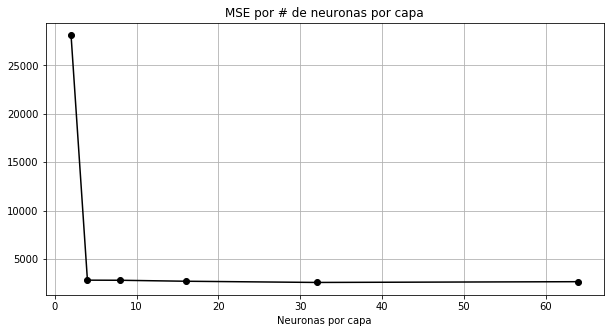

In [45]:
# gráfico del error
plt.figure(figsize=(10,5))
plt.xlabel('Neuronas por capa')
plt.title("MSE por # de neuronas por capa")
plt.plot(neuronas_por_capa, history_neuron, 'ko-')
plt.grid()

In [46]:
# seleccionamos el valor de 8 y ahora vamos a ajustar el número de capas ocultas
capas = [[8],[8,8],[8,8,8],[8,8,8,8],[8,8,8,8,8],[8,8,8,8,8,8]]

In [47]:
history_layers = []

for i in capas:

    model = tf.estimator.DNNRegressor(hidden_units=i,feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])

    history_layers.append(mean_squared_error(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmpj6_xjpsg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EF6EF3F2E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

INFO:tensorflow:global_step/sec: 201.184
INFO:tensorflow:loss = 26229.19, step = 301 (0.500 sec)
INFO:tensorflow:global_step/sec: 196.069
INFO:tensorflow:loss = 45252.0, step = 401 (0.510 sec)
INFO:tensorflow:global_step/sec: 194.916
INFO:tensorflow:loss = 34392.742, step = 501 (0.515 sec)
INFO:tensorflow:global_step/sec: 203.237
INFO:tensorflow:loss = 10297.916, step = 601 (0.495 sec)
INFO:tensorflow:global_step/sec: 194.535
INFO:tensorflow:loss = 35544.156, step = 701 (0.515 sec)
INFO:tensorflow:global_step/sec: 182.135
INFO:tensorflow:loss = 46767.055, step = 801 (0.548 sec)
INFO:tensorflow:global_step/sec: 187.602
INFO:tensorflow:loss = 64354.12, step = 901 (0.529 sec)
INFO:tensorflow:global_step/sec: 193.783
INFO:tensorflow:loss = 48854.668, step = 1001 (0.513 sec)
INFO:tensorflow:global_step/sec: 190.825
INFO:tensorflow:loss = 21530.752, step = 1101 (0.529 sec)
INFO:tensorflow:global_step/sec: 199.583
INFO:tensorflow:loss = 17728.133, step = 1201 (0.496 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 166.099
INFO:tensorflow:loss = 41653.293, step = 1901 (0.586 sec)
INFO:tensorflow:global_step/sec: 185.171
INFO:tensorflow:loss = 17667.367, step = 2001 (0.548 sec)
INFO:tensorflow:global_step/sec: 176.977
INFO:tensorflow:loss = 52956.1, step = 2101 (0.566 sec)
INFO:tensorflow:global_step/sec: 191.186
INFO:tensorflow:loss = 20138.316, step = 2201 (0.518 sec)
INFO:tensorflow:global_step/sec: 189.74
INFO:tensorflow:loss = 25501.244, step = 2301 (0.521 sec)
INFO:tensorflow:global_step/sec: 197.612
INFO:tensorflow:loss = 24828.09, step = 2401 (0.514 sec)
INFO:tensorflow:global_step/sec: 199.984
INFO:tensorflow:loss = 41668.54, step = 2501 (0.500 sec)
INFO:tensorflow:global_step/sec: 192.291
INFO:tensorflow:loss = 39673.977, step = 2601 (0.517 sec)
INFO:tensorflow:global_step/sec: 201.191
INFO:tensorflow:loss = 28427.658, step = 2701 (0.493 sec)
INFO:tensorflow:global_step/sec: 186.901
INFO:tensorflow:loss = 29030.049, step = 2801 (0.536 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 327.842
INFO:tensorflow:loss = 26037.488, step = 3501 (0.305 sec)
INFO:tensorflow:global_step/sec: 276.22
INFO:tensorflow:loss = 46974.938, step = 3601 (0.363 sec)
INFO:tensorflow:global_step/sec: 265.23
INFO:tensorflow:loss = 41061.78, step = 3701 (0.377 sec)
INFO:tensorflow:global_step/sec: 202.413
INFO:tensorflow:loss = 40862.51, step = 3801 (0.497 sec)
INFO:tensorflow:global_step/sec: 218.8
INFO:tensorflow:loss = 29716.723, step = 3901 (0.453 sec)
INFO:tensorflow:global_step/sec: 280.088
INFO:tensorflow:loss = 22595.71, step = 4001 (0.360 sec)
INFO:tensorflow:global_step/sec: 276.986
INFO:tensorflow:loss = 34606.414, step = 4101 (0.358 sec)
INFO:tensorflow:global_step/sec: 249.357
INFO:tensorflow:loss = 39477.03, step = 4201 (0.398 sec)
INFO:tensorflow:global_step/sec: 270.244
INFO:tensorflow:loss = 35099.363, step = 4301 (0.376 sec)
INFO:tensorflow:global_step/sec: 272.461
INFO:tensorflow:loss = 49702.734, step = 4401 (0.366 sec)
INFO:tensorflow:gl

INFO:tensorflow:Loss for final step: 28129.61.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\camig\AppData\Local\Temp\tmp6nrxtypo\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmp3ykg3wr6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.pytho

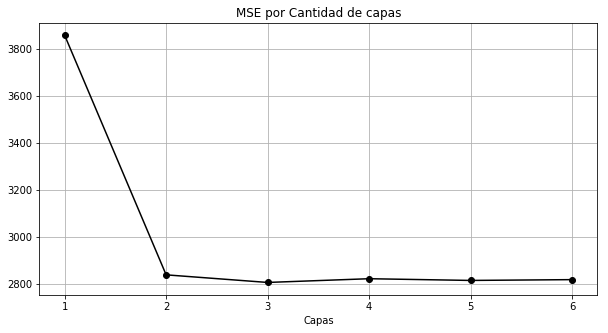

In [48]:
# seleccionamos el valor de 2 

plt.figure(figsize=(10,5))
plt.xlabel('Capas')
plt.title("MSE por Cantidad de capas")
plt.plot([1,2,3,4,5,6], history_layers, 'ko-')

plt.grid()

**Ahora vamos a entrenar nuestro modelo con los dos hyperparámetros más óptimos encontrados, 2 capas ocultas de 8 neuronas por capa oculta, pero cambiando los feature_columns**

In [49]:
lista_feat_cols = [[bmi,bp,s4,s5],[bmi, bp,s2,s5,s6],[sex, bmi, bp, s1, s2, s4, s5, s6]]

#### Modelo final con la Api.estimator:
     * Variables          [sex, bmi, bp, s1, s2, s4, s5, s6]
     * Capas              2
     * Neuronas por capa  8

In [50]:
tf.reset_default_graph()

feat_cols = [sex, bmi, bp, s1, s2, s4, s5, s6]

model = tf.estimator.DNNRegressor(hidden_units=[8,8],feature_columns=feat_cols)

model.train(input_fn=input_func,steps=5000)

predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

pred_gen = model.predict(predict_input_func)

predictions = list(pred_gen)

final_preds = []

for pred in predictions:
    final_preds.append(pred['predictions'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmpjh4yscx5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EF72510BA8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

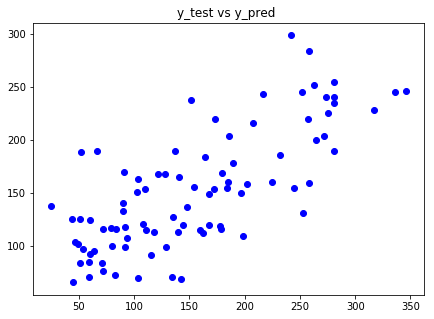

In [58]:
plt.figure(figsize=(7,5))
plt.title("y_test vs y_pred ")
plt.scatter(y_test,final_preds,color="blue")

In [52]:
mae_nn =  metrics.mean_absolute_error(y_test, final_preds)
mse_nn =  metrics.mean_squared_error(y_test, final_preds)
rmse_nn = np.sqrt(metrics.mean_squared_error(y_test, final_preds))

print(mae_nn,mse_nn,rmse_nn)

44.24787611372015 2877.2435022594286 53.6399431604791


In [53]:
resultados_tf_estimator = [mae_nn,mse_nn,rmse_nn]

## Cross validation

In [54]:
X = diabetes_set.drop(["Y"],axis = 1).values
y = diabetes_set["Y"].values

In [55]:
def cross_validation(train_index, test_index,X,y):    
    
    X_train, X_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index])
    y_train, y_test = pd.DataFrame(y[train_index]), pd.DataFrame(y[test_index])
    
    X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    X_test.columns = X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    #y_train.columns = ["Y"]
    #y_test.columns = ["Y"]
    
    sex = tf.feature_column.numeric_column('sex')
    bmi = tf.feature_column.numeric_column('bmi')
    bp = tf.feature_column.numeric_column('bp')
    s1 = tf.feature_column.numeric_column('s1')
    s2 = tf.feature_column.numeric_column('s2')
    s4 = tf.feature_column.numeric_column('s4')
    s5 = tf.feature_column.numeric_column('s5')
    s6 = tf.feature_column.numeric_column('s6')

    feat_cols = [sex, bmi, bp, s1, s2,s4, s5, s6]

    input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                     y= y_train[0],
                                                     batch_size=10,
                                                     num_epochs=3000,
                                                     shuffle=False)
    
    model = tf.estimator.DNNRegressor(hidden_units=[4,4,4],feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])   

    return metrics.mean_squared_error(y_test, final_preds)
   

In [56]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

resultado_cross = []

for train_index, test_index in kf.split(X):    

    resultado_cross.append(cross_validation(train_index,test_index,X,y))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\camig\\AppData\\Local\\Temp\\tmpgmefxnq4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EF73C10DA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

INFO:tensorflow:global_step/sec: 163.247
INFO:tensorflow:loss = 38451.566, step = 301 (0.610 sec)
INFO:tensorflow:global_step/sec: 142.438
INFO:tensorflow:loss = 75007.97, step = 401 (0.708 sec)
INFO:tensorflow:global_step/sec: 138.515
INFO:tensorflow:loss = 57640.625, step = 501 (0.719 sec)
INFO:tensorflow:global_step/sec: 178.557
INFO:tensorflow:loss = 37296.266, step = 601 (0.563 sec)
INFO:tensorflow:global_step/sec: 162.853
INFO:tensorflow:loss = 34651.83, step = 701 (0.607 sec)
INFO:tensorflow:global_step/sec: 70.2189
INFO:tensorflow:loss = 25314.115, step = 801 (1.426 sec)
INFO:tensorflow:global_step/sec: 192.662
INFO:tensorflow:loss = 19325.771, step = 901 (0.515 sec)
INFO:tensorflow:global_step/sec: 196.062
INFO:tensorflow:loss = 54750.906, step = 1001 (0.515 sec)
INFO:tensorflow:global_step/sec: 187.953
INFO:tensorflow:loss = 47800.684, step = 1101 (0.534 sec)
INFO:tensorflow:global_step/sec: 208.318
INFO:tensorflow:loss = 24252.934, step = 1201 (0.475 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 163.393
INFO:tensorflow:loss = 40705.875, step = 1901 (0.604 sec)
INFO:tensorflow:global_step/sec: 171.514
INFO:tensorflow:loss = 20024.45, step = 2001 (0.590 sec)
INFO:tensorflow:global_step/sec: 183.808
INFO:tensorflow:loss = 25094.441, step = 2101 (0.541 sec)
INFO:tensorflow:global_step/sec: 176.036
INFO:tensorflow:loss = 36137.258, step = 2201 (0.561 sec)
INFO:tensorflow:global_step/sec: 190.466
INFO:tensorflow:loss = 37724.13, step = 2301 (0.527 sec)
INFO:tensorflow:global_step/sec: 189.022
INFO:tensorflow:loss = 47555.133, step = 2401 (0.534 sec)
INFO:tensorflow:global_step/sec: 187.601
INFO:tensorflow:loss = 45166.043, step = 2501 (0.533 sec)
INFO:tensorflow:global_step/sec: 186.551
INFO:tensorflow:loss = 39416.254, step = 2601 (0.539 sec)
INFO:tensorflow:global_step/sec: 137.348
INFO:tensorflow:loss = 35685.996, step = 2701 (0.730 sec)
INFO:tensorflow:global_step/sec: 135.314
INFO:tensorflow:loss = 30398.621, step = 2801 (0.730 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 157.21
INFO:tensorflow:loss = 30351.627, step = 3501 (0.640 sec)
INFO:tensorflow:global_step/sec: 172.274
INFO:tensorflow:loss = 39585.637, step = 3601 (0.582 sec)
INFO:tensorflow:global_step/sec: 156.238
INFO:tensorflow:loss = 46400.5, step = 3701 (0.644 sec)
INFO:tensorflow:global_step/sec: 170.054
INFO:tensorflow:loss = 30591.7, step = 3801 (0.582 sec)
INFO:tensorflow:global_step/sec: 187.601
INFO:tensorflow:loss = 27899.36, step = 3901 (0.542 sec)
INFO:tensorflow:global_step/sec: 168.054
INFO:tensorflow:loss = 20583.71, step = 4001 (0.586 sec)
INFO:tensorflow:global_step/sec: 166.653
INFO:tensorflow:loss = 19300.354, step = 4101 (0.600 sec)
INFO:tensorflow:global_step/sec: 175.425
INFO:tensorflow:loss = 18862.557, step = 4201 (0.577 sec)
INFO:tensorflow:global_step/sec: 163.652
INFO:tensorflow:loss = 16994.994, step = 4301 (0.601 sec)
INFO:tensorflow:global_step/sec: 147.047
INFO:tensorflow:loss = 26712.926, step = 4401 (0.689 sec)
INFO:tensorflow:g

In [57]:
print("MSE Cross validation: ", np.array(resultado_cross).sum()/len(resultado_cross))

MSE Cross validation:  3043.9148018800993
